In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [3]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform
#from fastcluster import linkage

In [4]:
%matplotlib inline

In [5]:
bird = 'B1597'
timestamp = '2021-05-14_12-40-20_423998' 

In [6]:
spikesorting_folder = (DATA_DIR
            / "spikesorting"
            / bird
            / timestamp)

In [7]:
recording_summary_df = pd.read_pickle(spikesorting_folder/ 'recording_df.pickle')

In [8]:
recording_summary_df[:1]

,dat_file,sample_rate,channels,n_samples,experiment_num,recording_num,date_str,num_channels_total,ADC_data_channels,site,...,dat_size_gb,n_ttl_events,n_trials,n_playbacks,n_response,n_punish,n_reward,n_hours,recording_id,site_loc
0,/mnt/sphere/RawData/Samamba/ephys/B1597/2021-0...,30000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",827683072,1,1,2021-05-13_14-35-47_1150,72,"[64, 65, 66, 67, 68, 69, 70, 71]",5,...,119.186362,12532,8,6217,0,0,0,7.663732,exp1_rec1_dat2021-05-13_14-35-47_1150,2420_2240_1150_R


In [9]:
# unit information
unit_features = pd.read_pickle(spikesorting_folder / 'recording_features_merged_units.pickle')

In [10]:
unit_features[:1]

,template,presence_ratio,isi_violations_rate,max_channel,center_of_mass_x,center_of_mass_y,spike_amplitude,amp_channel_0,amp_channel_1,amp_channel_2,...,n_spikes,recording_id,datetime,unit,n_hours,spike_rate,good_unit,z_score_template,median_relative_channel_max,cluster_id
0,"[[21.0, 4.0, 22.0, 0.0, 39.0, 13.0, -11.0, -10...",1.0,0.00946,0,66.835239,24.62578,-1239.0,1239.0,140.0,43.0,...,78741,exp1_rec1_dat2021-05-13_14-35-47_1150,2021-05-13 14:35:47.115,0,7.663732,2.854027,True,"[[0.40623679964006376, -0.020724543118155827, ...",0.027476,0


### Create a dataframe listing # playbacks for each unit

In [11]:
from scipy.ndimage import gaussian_filter1d

def get_psth_from_trial_aligned_spikes(
    trial_aligned_spikes_loc, padding_s=0, nbins=200, gaussian_sigma_ms = 5
):
    bin_ms=1000 / nbins
    gaussian_sigma = gaussian_sigma_ms / bin_ms

    trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
    # get cue info
    trial_aligned_spikes["cue"] = [
        i.split("_")[0] for i in trial_aligned_spikes.stim.values
    ]
    trial_aligned_spikes["interp"] = [
        i.split("_")[1] for i in trial_aligned_spikes.stim.values
    ]
    trial_aligned_spikes["interp_point"] = [
        int(i.split("_")[2]) for i in trial_aligned_spikes.stim.values
    ]
    # align times
    trial_aligned_spikes.loc[
        trial_aligned_spikes.cue.isin(["CL1", "CL0", "CN", "CR0", "CR1"]),
        "stim_length",
    ] = 2
    trial_aligned_spikes.loc[trial_aligned_spikes.cue.isin(["NC"]), "stim_length"] = 1

    spike_psth = []
    for idx, row in tqdm(
        trial_aligned_spikes.iterrows(), total=len(trial_aligned_spikes), leave=False
    ):
        if row.cue in ["CL1", "CL0", "CN", "CR0", "CR1"]:
            bins = np.linspace(1, 2, nbins)
        else:
            bins = np.linspace(0, 1, nbins)

        # bins = np.linspace(-padding_s, row.stim_length + padding_s, nbins)
        hist, bin_edges = np.histogram(row.spike_times, bins, density=False)
        gauss_convolved_psth = gaussian_filter1d(
            hist.astype("float"), gaussian_sigma, mode="constant"
        )
        spike_psth.append(gauss_convolved_psth)

    trial_aligned_spikes["psth"] = spike_psth
    # psth_array = np.vstack(
    #    trial_aligned_spikes[trial_aligned_spikes.stim_length == 2]
    #    .sort_values(by=["cue", "interp", "interp_point"])
    #    .psth.values
    #
    # )
    return trial_aligned_spikes

In [12]:
sorter = 'kilosort2_5'

In [13]:
unit_features = pd.read_pickle(spikesorting_folder / 'unit_clusters.pickle')
len(unit_features)

13787

In [14]:
unit_features = unit_features.sort_values(by='n_playbacks', ascending=False)
unit_features[:3]

,cluster_id,n_spikes,n_trials,n_playbacks,sort_units
3059,3428,40848147,27960.0,136273.0,"[(231, exp1_rec1_dat2021-05-18_09-10-29_1150),..."
4318,4957,18987348,17933.0,94700.0,"[(88, exp1_rec1_dat2021-05-21_22-32-02_1150), ..."
7237,8542,5758671,18521.0,77227.0,"[(18, exp1_rec1_dat2021-05-28_22-06-52_1150), ..."


### single unit

In [15]:
from scipy.ndimage import gaussian_filter1d

def get_psth_from_trial_aligned_spikes(
    trial_aligned_spikes_loc, padding_s=0, nbins=200, gaussian_sigma_ms = 5
):
    bin_ms=1000 / nbins
    gaussian_sigma = gaussian_sigma_ms / bin_ms

    trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
    # get cue info
    trial_aligned_spikes["cue"] = [
        i.split("_")[0] for i in trial_aligned_spikes.stim.values
    ]
    trial_aligned_spikes["interp"] = [
        i.split("_")[1] for i in trial_aligned_spikes.stim.values
    ]
    trial_aligned_spikes["interp_point"] = [
        int(i.split("_")[2]) for i in trial_aligned_spikes.stim.values
    ]
    # align times
    trial_aligned_spikes.loc[
        trial_aligned_spikes.cue.isin(["CL1", "CL0", "CN", "CR0", "CR1"]),
        "stim_length",
    ] = 2
    trial_aligned_spikes.loc[trial_aligned_spikes.cue.isin(["NC"]), "stim_length"] = 1

    spike_psth = []
    for idx, row in tqdm(
        trial_aligned_spikes.iterrows(), total=len(trial_aligned_spikes), leave=False
    ):
        if row.cue in ["CL1", "CL0", "CN", "CR0", "CR1"]:
            bins = np.linspace(1, 2, nbins)
        else:
            bins = np.linspace(0, 1, nbins)

        # bins = np.linspace(-padding_s, row.stim_length + padding_s, nbins)
        hist, bin_edges = np.histogram(row.spike_times, bins, density=False)
        gauss_convolved_psth = gaussian_filter1d(
            hist.astype("float"), gaussian_sigma, mode="constant"
        )
        spike_psth.append(gauss_convolved_psth)

    trial_aligned_spikes["psth"] = spike_psth
    # psth_array = np.vstack(
    #    trial_aligned_spikes[trial_aligned_spikes.stim_length == 2]
    #    .sort_values(by=["cue", "interp", "interp_point"])
    #    .psth.values
    #
    # )
    return trial_aligned_spikes

In [16]:
cluster_row = unit_features.iloc[0]

In [17]:
cluster_row

cluster_id                                                  3428
n_spikes                                                40848147
n_trials                                                 27960.0
n_playbacks                                             136273.0
sort_units     [(231, exp1_rec1_dat2021-05-18_09-10-29_1150),...
Name: 3059, dtype: object

In [18]:
nbins=100
gaussian_sigma_ms = 25

In [19]:
trial_aligned_spikes_list = []
for unit, recording_id in tqdm(cluster_row.sort_units):
    trial_aligned_spikes_loc = (
        spikesorting_folder
        / "trial_aligned_spikes"
        / sorter
        / recording_id
        / "{}.pickle".format(unit)
    )
    if trial_aligned_spikes_loc.exists():
        #trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
        trial_aligned_spikes = get_psth_from_trial_aligned_spikes(trial_aligned_spikes_loc, gaussian_sigma_ms=gaussian_sigma_ms, nbins=nbins)
        trial_aligned_spikes['recording_id'] = recording_id
        
        trial_aligned_spikes_list.append(trial_aligned_spikes)
    else:
        print("{} does not have trial aligned spikes yet".format(recording_id))
trial_aligned_spikes = pd.concat(trial_aligned_spikes_list).sort_values(by=['cue', 'interp','interp_point'])
#trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.interp == 'AE']
len(trial_aligned_spikes)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/7167 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-18_22-39-21_1150 does not have trial aligned spikes yet


  0%|          | 0/5360 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-19_22-14-41_1150 does not have trial aligned spikes yet


  0%|          | 0/5907 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-20_22-28-13_1150 does not have trial aligned spikes yet


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/6057 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/5594 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/6279 [00:00<?, ?it/s]

  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/6358 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-24_22-20-05_1150 does not have trial aligned spikes yet


  0%|          | 0/7132 [00:00<?, ?it/s]

  0%|          | 0/1099 [00:00<?, ?it/s]

  0%|          | 0/6809 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-26_22-37-58_1150 does not have trial aligned spikes yet


  0%|          | 0/1273 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/5839 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-28_22-06-52_1150 does not have trial aligned spikes yet


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4755 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-30_09-19-41_1150 does not have trial aligned spikes yet


  0%|          | 0/5612 [00:00<?, ?it/s]

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/6732 [00:00<?, ?it/s]

exp1_rec1_dat2021-05-31_22-08-20_1150 does not have trial aligned spikes yet


  0%|          | 0/6719 [00:00<?, ?it/s]

exp1_rec1_dat2021-06-01_22-18-13_1150 does not have trial aligned spikes yet


  0%|          | 0/5676 [00:00<?, ?it/s]

  0%|          | 0/1085 [00:00<?, ?it/s]

  0%|          | 0/6049 [00:00<?, ?it/s]

exp1_rec1_dat2021-06-05_21-46-16_1150 does not have trial aligned spikes yet


  0%|          | 0/5776 [00:00<?, ?it/s]

exp1_rec1_dat2021-06-06_21-35-31_1150 does not have trial aligned spikes yet


  0%|          | 0/6861 [00:00<?, ?it/s]

  0%|          | 0/8087 [00:00<?, ?it/s]

  0%|          | 0/1573 [00:00<?, ?it/s]

  0%|          | 0/6638 [00:00<?, ?it/s]

135308

In [61]:
trial_aligned_spikes[:3]

,stim,trial_id,frame_begin,correct,response,punish,reward,stim_length,unit,spike_times,passive,n_spikes,cue,interp,interp_point,psth,recording_id
0,CL0_AE_000,2021-05-22 13:17:55.632232,226098933,True,right,False,False,2.0,152,"[0.10996666666666667, 0.5805, 0.71496666666666...",False,42,CL0,AE,0,"[0.5198556231836214, 0.5955750524039285, 0.592...",exp1_rec1_dat2021-05-22_11-12-19_1150
0,CL0_AE_000,2021-06-01 16:19:52.823851,833715332,False,left,True,False,2.0,114,"[0.06536666666666667, 0.09776666666666667, 0.1...",False,67,CL0,AE,0,"[0.07792102222031275, 0.11683301442228282, 0.1...",exp1_rec1_dat2021-06-01_08-36-42_1150
1,CL0_AE_000,2021-06-01 16:20:03.436133,834033711,True,right,False,False,2.0,114,"[0.026333333333333334, 0.09426666666666667, 0....",False,89,CL0,AE,0,"[0.6912514832172525, 0.8611442370182582, 0.968...",exp1_rec1_dat2021-06-01_08-36-42_1150


In [21]:
interp_spikes = trial_aligned_spikes[trial_aligned_spikes.interp == 'BF'].sort_values(by='interp_point')
len(interp_spikes)

28238

In [22]:
point_spikes = interp_spikes[interp_spikes.interp_point ==127].sort_values(by='recording_id')
len(point_spikes)

195

In [23]:
point_spikes[:3]

,stim,trial_id,frame_begin,correct,response,punish,reward,stim_length,unit,spike_times,passive,n_spikes,cue,interp,interp_point,psth,recording_id
2,CR1_BF_127,exp1_rec1_dat2021-05-18_09-10-29_1150_1256509424,1256509424,NaN,NaN,NaN,NaN,2.0,231,"[0.14353333333333335, 0.15063333333333334, 0.4...",True,16,CR1,BF,127,"[0.16986208788353602, 0.2071163159897432, 0.23...",exp1_rec1_dat2021-05-18_09-10-29_1150
1,CR1_BF_127,exp1_rec1_dat2021-05-18_09-10-29_1150_1111282526,1111282526,NaN,NaN,NaN,NaN,2.0,231,"[0.1264, 0.28833333333333333, 0.44486666666666...",True,16,CR1,BF,127,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",exp1_rec1_dat2021-05-18_09-10-29_1150
3,NC_BF_127,exp1_rec1_dat2021-05-18_09-10-29_1150_1138146104,1138146104,NaN,NaN,NaN,NaN,1.0,231,"[0.11446666666666666, 0.2912666666666667, 0.61...",True,6,NC,BF,127,"[0.0, 5.353335404957566e-05, 0.000244766550165...",exp1_rec1_dat2021-05-18_09-10-29_1150


In [24]:
point_spikes['date'] = [datetime.datetime.strptime(i.split('_')[2][3:], "%Y-%m-%d") for i in point_spikes.recording_id.values]

In [25]:
point_spikes = point_spikes.sort_values(by='date')

In [26]:
dtstart = point_spikes.iloc[0].date
dtend = point_spikes.iloc[-1].date

In [27]:
n_days = (dtend - dtstart).days
n_days

22

[]

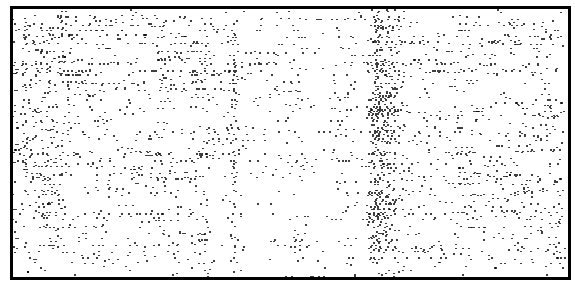

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
for ii, (idx, row) in enumerate(point_spikes.iterrows()):
    if row.stim_length == 2:
        spike_times = row.spike_times[row.spike_times>1] -1
    else:
        spike_times = row.spike_times
    ax.vlines(spike_times, ymin=ii, ymax = ii+1, color = 'k')
ax.set_ylim([0, len(point_spikes)+1])
ax.set_xlim([0,1])
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

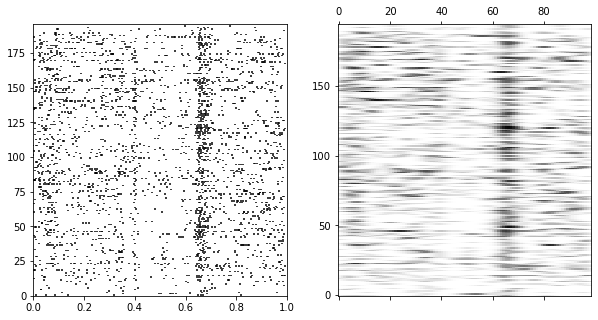

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
for ii, (idx, row) in enumerate(point_spikes.iterrows()):
    if row.stim_length == 2:
        spike_times = row.spike_times[row.spike_times>1] -1
    else:
        spike_times = row.spike_times
    ax.vlines(spike_times, ymin=ii, ymax = ii+1, color = 'k')
ax.set_ylim([0, len(point_spikes)+1])
ax.set_xlim([0,1])
#ax.axis('off')
ax = axs[1]
psth = np.vstack(point_spikes.psth.values)
psth = np.log(1+psth)
ax.matshow(psth, cmap = plt.cm.Greys, origin = 'lower', aspect='auto')
plt.show()

In [30]:
point_spikes.iloc[0].spike_times

array([0.14353333, 0.15063333, 0.42503333, 0.4358    , 0.75183333,
       0.97563333, 0.9793    , 1.01033333, 1.05146667, 1.08406667,
       1.1348    , 1.31833333, 1.65096667, 1.66116667, 1.66833333,
       1.81953333])

In [74]:
ex = 5

In [75]:
row = point_spikes.iloc[ex]

In [76]:
row.cue

'CR1'

In [77]:
if row.cue in ["CN", "CL0", "CL1", "CR0", "CR1"]:
    st = row.spike_times[row.spike_times >1] - 1
    print(st)
else:
    st = row.spike_times

[0.06186667 0.21363333 0.34736667 0.4128     0.6773     0.7026
 0.71776667]


[]

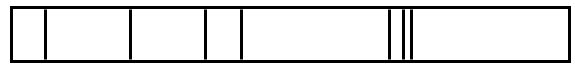

In [78]:
fig, ax = plt.subplots(nrows=1, figsize=(10,1))
ax.vlines(st, 0,1, color='k', lw=3)
ax.set_xlim([0,1])
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

[]

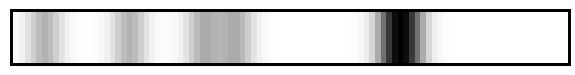

In [79]:
fig, ax = plt.subplots(nrows=1, figsize=(10,1))
ax.set_xlim([0,len(row.psth)])
ax.matshow(np.expand_dims(row.psth,0), aspect='auto', cmap = plt.cm.Greys)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])
#ax.axis('off')

(-3.3, 3.3, -0.015284516835152185, 0.418475518600832)

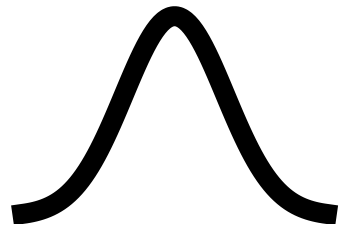

In [80]:
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
fig, ax = plt.subplots()
ax.plot(x, stats.norm.pdf(x, mu, sigma), color='k', lw=20)
ax.axis('off')

### plot interpolation

In [38]:
interp_psth = ([np.mean(interp_spikes[interp_spikes.interp_point == i].psth,axis=0) for i in np.arange(128)])
    

[]

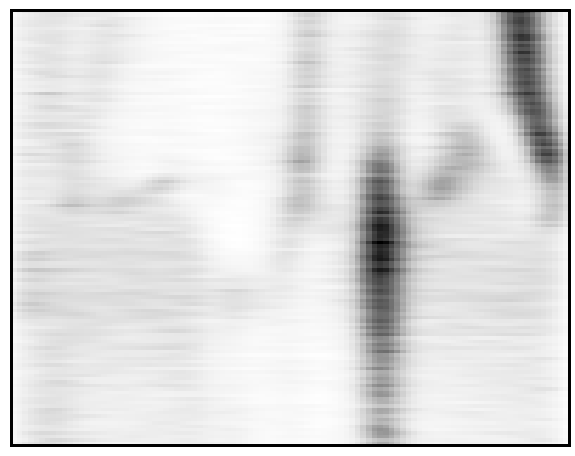

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
ax.matshow(interp_psth, cmap = plt.cm.Greys, aspect='auto')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

In [40]:
def zero_one_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

from matplotlib.colors import LinearSegmentedColormap
def get_cmap(interp, left_to_right_colors=["#e69138", "#6aa84f"]):
    n_samp = len(interp)

    categorical_gradient_cmap = LinearSegmentedColormap.from_list(
        "left_to_right", left_to_right_colors, N=n_samp
    )
    cmaps = {}
    for gpi, grad_point in enumerate(
        categorical_gradient_cmap(np.linspace(0, 1, n_samp))
    ):
        cmaps[gpi] = LinearSegmentedColormap.from_list(
            "test", [(0.95, 0.95, 0.95, 1), grad_point], N=512
        )
    mapped = np.stack([cmaps[i](j) for i, j in enumerate(zero_one_norm(interp))])
    return mapped

[]

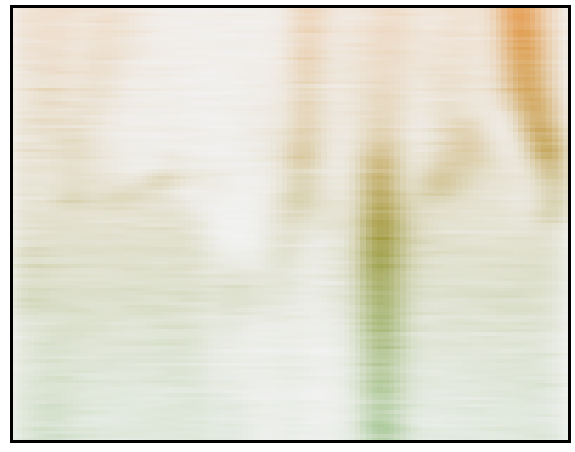

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(get_cmap(zero_one_norm(interp_psth)), interpolation='None', aspect="auto")
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

[]

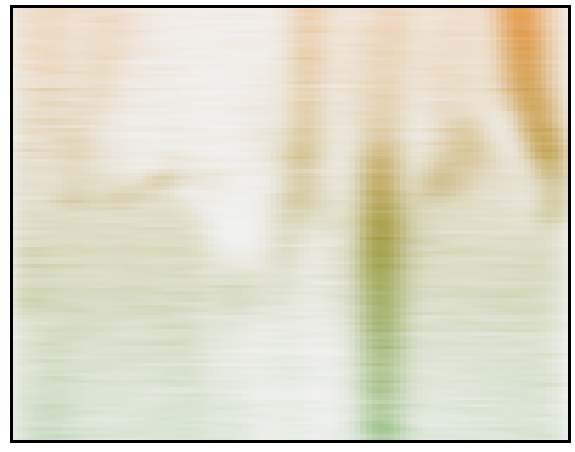

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(get_cmap(zero_one_norm(np.log(np.array(interp_psth)+1))), interpolation='None', aspect="auto")
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

[]

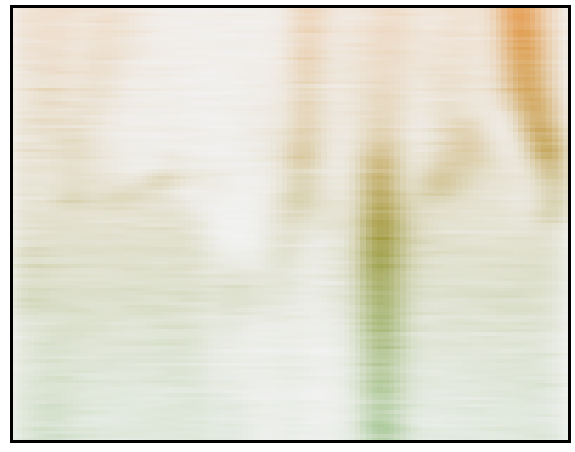

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(get_cmap(zero_one_norm(interp_psth)), interpolation='None', aspect="auto", )
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

[]

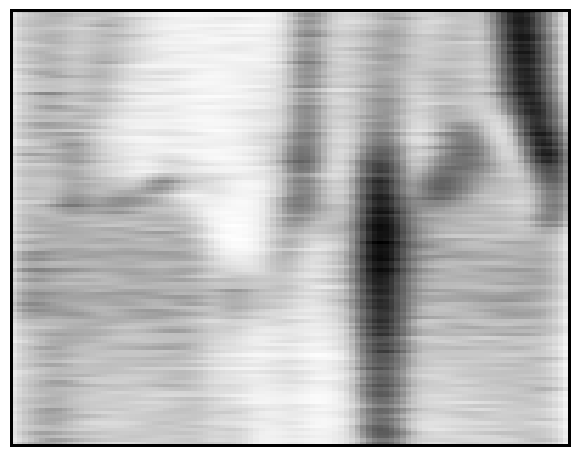

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
ax.matshow(np.log(1e-1+np.array(interp_psth)), cmap = plt.cm.Greys, aspect='auto')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xticks([])
ax.set_yticks([])

### plot interpolation by cue

In [45]:
interp_spikes[:3]

,stim,trial_id,frame_begin,correct,response,punish,reward,stim_length,unit,spike_times,passive,n_spikes,cue,interp,interp_point,psth,recording_id
0,CL0_BF_000,exp1_rec1_dat2021-05-18_09-10-29_1150_847422510,847422510,NaN,NaN,NaN,NaN,2.0,231,"[0.0664, 0.19373333333333334, 0.30206666666666...",True,9,CL0,BF,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",exp1_rec1_dat2021-05-18_09-10-29_1150
1,CR1_BF_000,2021-06-08 07:09:03.366192,9040183,True,right,False,False,2.0,64,"[0.0057666666666666665, 0.0577, 0.0606, 0.0632...",False,29,CR1,BF,0,"[0.008958023586943172, 0.021596896435839737, 0...",exp1_rec1_dat2021-06-08_07-04-02_1150
1,CR0_BF_000,2021-06-09 09:17:23.579378,1249279214,True,right,False,False,2.0,53,"[0.07656666666666667, 0.20133333333333334, 0.7...",False,33,CR0,BF,0,"[0.25105646369595036, 0.3748330879044569, 0.49...",exp1_rec1_dat2021-06-08_21-43-21_1150


In [46]:
len(interp_spikes)

28238

In [47]:
for i in interp_psth:
    print(len(i))

99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99


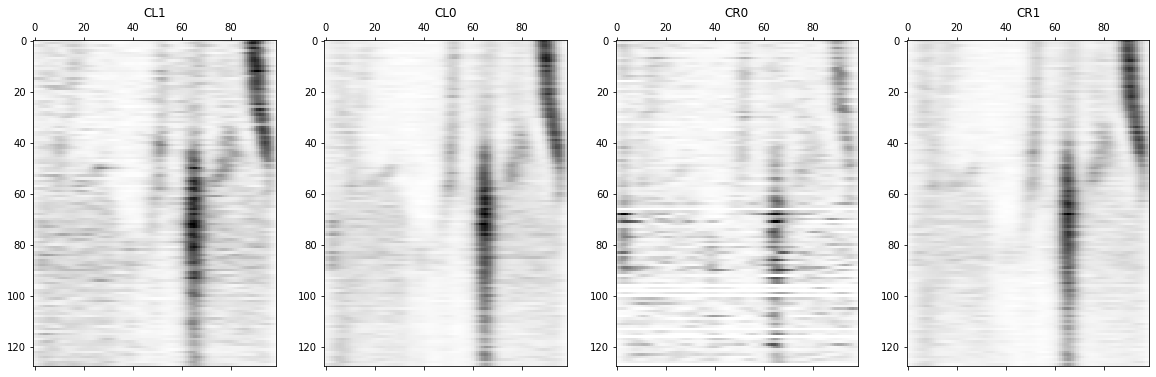

In [48]:
cues = ["CL1", "CL0",  "CR0", "CR1"]
fig, axs = plt.subplots(ncols=len(cues), figsize=(20,6))
for ci,cue in enumerate(cues):
    cue_spikes = interp_spikes[interp_spikes.cue == cue]
    interp_psth = ([np.mean(cue_spikes[cue_spikes.interp_point == i].psth,axis=0) for i in np.arange(128)])
    interp_psth = [i if type(i)==np.ndarray else np.zeros(99) for i in interp_psth]
    ax = axs[ci]
    ax.matshow(interp_psth, cmap = plt.cm.Greys, aspect='auto')
    ax.set_title(cue)

In [49]:
from cdcp.visualization.colors import colors
colors

{'cue': {'L': {'dark': '#4D3A7D',
   'light': '#674ea7',
   0.875: '#4D3A7D',
   0.75: '#674ea7',
   0.25: '#B05280',
   0.125: '#7D3A5B',
   0.5: '#666666'},
  'R': {'dark': '#7D3A5B',
   'light': '#B05280',
   0.875: '#7D3A5B',
   0.75: '#B05280',
   0.25: '#674ea7',
   0.125: '#4D3A7D',
   0.5: '#666666'},
  'N': {'dark': '#000000',
   'light': '#666666',
   0.75: '#666666',
   0.5: '#666666',
   0.25: '#666666',
   0.125: '#666666',
   0.875: '#666666'},
  'C': {'dark': '#000000',
   'light': '#666666',
   0.75: '#666666',
   0.5: '#666666',
   0.25: '#666666',
   0.125: '#666666',
   0.875: '#666666'}},
 'reinforce': {'L': {'dark': '#e69138', 'light': '#fce5cd'},
  'R': {'dark': '#6aa84f', 'light': '#d9ead3'}},
 'cue_type': {'CL': '#4D3A7D',
  'CN': '#666666',
  'NC': '#666666',
  'CR': '#7D3A5B'},
 'cue_pal': {'NC': '#666666',
  'CN': '#333333',
  'CL1': '#4D3A7D',
  'CL0': '#674ea7',
  'CR1': '#7D3A5B',
  'CR0': '#B05280'}}

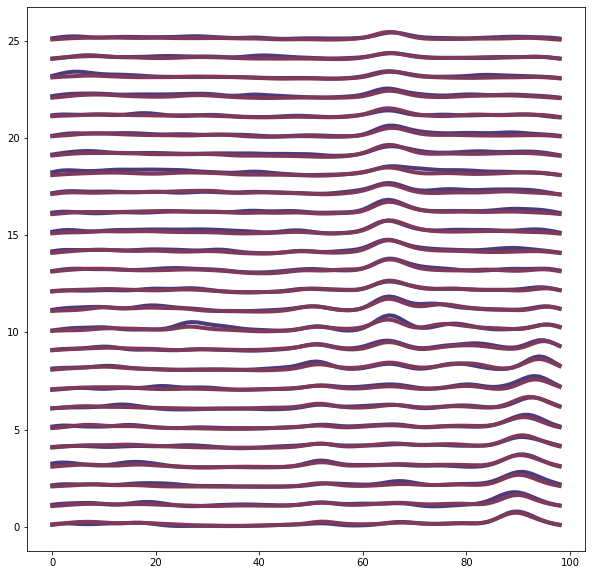

In [50]:
cues = ["CL1", "CR1"]
fig, ax = plt.subplots(figsize=(10,10))
for ci,cue in enumerate(cues):
    cue_spikes = interp_spikes[interp_spikes.cue == cue]
    interp_psth = ([np.mean(cue_spikes[cue_spikes.interp_point == i].psth,axis=0) for i in np.arange(128)])
    interp_psth = [i if type(i)==np.ndarray else np.zeros(99) for i in interp_psth]
    for ii, i in enumerate(interp_psth[::5]):
        plt.plot(ii+i, color = colors['cue_pal'][cue], lw=4)

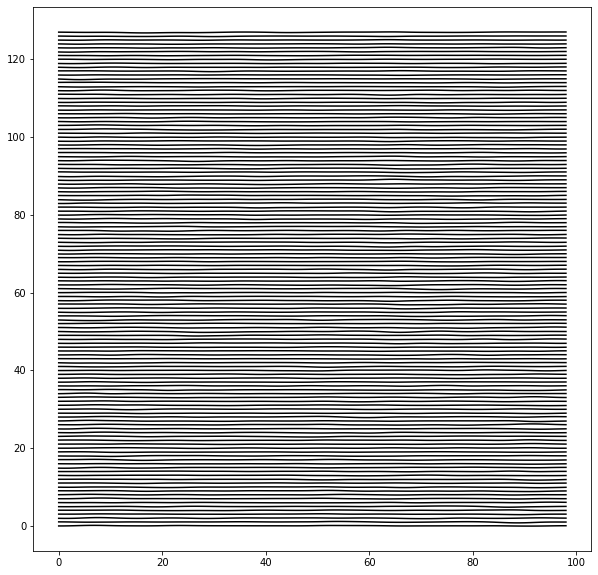

In [51]:
diff = np.zeros((128,99))
cues = ["CL1", "CR1"]
fig, ax = plt.subplots(figsize=(10,10))
for ci,cue in enumerate(cues):
    cue_spikes = interp_spikes[interp_spikes.cue == cue]
    interp_psth = ([np.mean(cue_spikes[cue_spikes.interp_point == i].psth,axis=0) for i in np.arange(128)])
    interp_psth = np.array([i if type(i)==np.ndarray else np.zeros(99) for i in interp_psth])
    if cue == "CL1":
        diff =- interp_psth
    else:
        diff += interp_psth
for ii, i in enumerate(diff):
    plt.plot(ii+i, color = 'k')

In [52]:
# pickled dataframes
interp_df = pd.read_pickle(DATA_DIR / 'interp_df_melspec.pickle')

In [53]:
# pickled dataframes
stim_df = pd.read_pickle(DATA_DIR / 'stim_df_melspec.pickle')

In [54]:
interp_df[:2]

,L,R,prop,pt,z,x_x_interp,x_z_interp,audio,mel_spec
0,A,B,0.000000,0,"[1.0914186239242554, -0.4693475067615509, -1.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.042301386813051e-06, 7.268283184203028e-07,...","[-12, -8, -44, -42, -54, -38, -39, -33, -48, -...","[[-39.531136, -39.316376, -38.798462, -38.2338..."
1,A,B,0.007874,1,"[1.070769041541993, -0.4643999143378941, -1.84...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.4460663300706074e-06, 8.483789883939608e-07...","[25, 31, 22, 15, -27, -39, -39, -52, -27, -27,...","[[-38.683086, -38.733887, -38.87696, -39.08884..."


In [55]:
audio = interp_df[(interp_df.L =='B') & (interp_df.R == 'F') & (interp_df.pt==127)].audio.values[0]

(0.0, 43912.0, -36024.65, 35797.65)

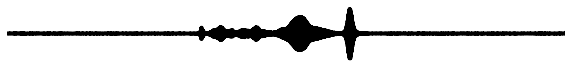

In [56]:
fig, ax = plt.subplots(figsize=(10,1))
plt.plot(audio, lw=4, color = 'k')
ax.set_xlim([0, len(audio)])
ax.axis('off')

In [57]:
import librosa
import librosa.display

In [58]:
audio = audio/ 32768.0

(-0.5, 343.5, -0.5, 256.5)

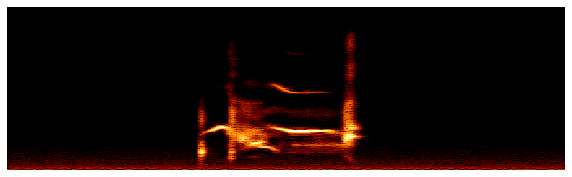

In [59]:
D = librosa.stft(audio, n_fft=512) 
S_db = librosa.amplitude_to_db(np.abs(D), ref=1, amin=0.02)
fig, ax = plt.subplots(figsize=(10,3))
ax.matshow(S_db, cmap = plt.cm.afmhot, aspect='auto', origin='lower')
ax.axis('off')

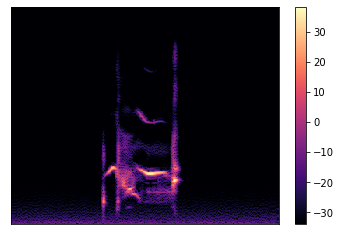

In [60]:
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()